## 点云滤波
- 汪星宇
- 2021年12月

早期的任务方案制定应该都是基于`PCL`库的, 这也为稳健地展开工程项目提供了一个优秀的参考. 因此这里将充分参考`PLC`及其教程, 主要利用`Open3D`和`numpy`进行功能验证实现.

`PCL`也提供了不同的滤波方式[参考用例](https://pcl.readthedocs.io/projects/tutorials/en/master/#:~:text=and%20pose%20estimation.-,Filtering,-Filtering%20a%20PointCloud).

### 1. 直通滤波
知识点的简单介绍，中文参考博客:
[点云滤波之直通滤波与体素法滤波](https://zhuanlan.zhihu.com/p/64226544)

点云直通滤波, 即`PCL`中的`PassThrough filter`, 指定字段，指定坐标范围进行剪裁，可以选择保留范围内的点或者范围外的点。

`Open3D`中没有与之直接对应的函数, 但是使用`numpy`可以轻易地实现这功能.

`Numpy`的`ndarray`转换成`pcd`格式数据，教程 [numpy 转 pointcloud](http://www.open3d.org/docs/0.12.0/tutorial/geometry/working_with_numpy.html)

主要实现步骤:
1. 建立合理的参数列表, 包括`坐标轴`, `限制区间`, `其他辅助参数`等
2. 格式转换, 利用`Numpy`的`ndarray`, 根据参数列表, 索引点云点, 再转回`PointCloud`格式

In [1]:
import numpy as np
import open3d as o3d

# 实现 notebook 行间显示功能
import open3d_tutorial

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


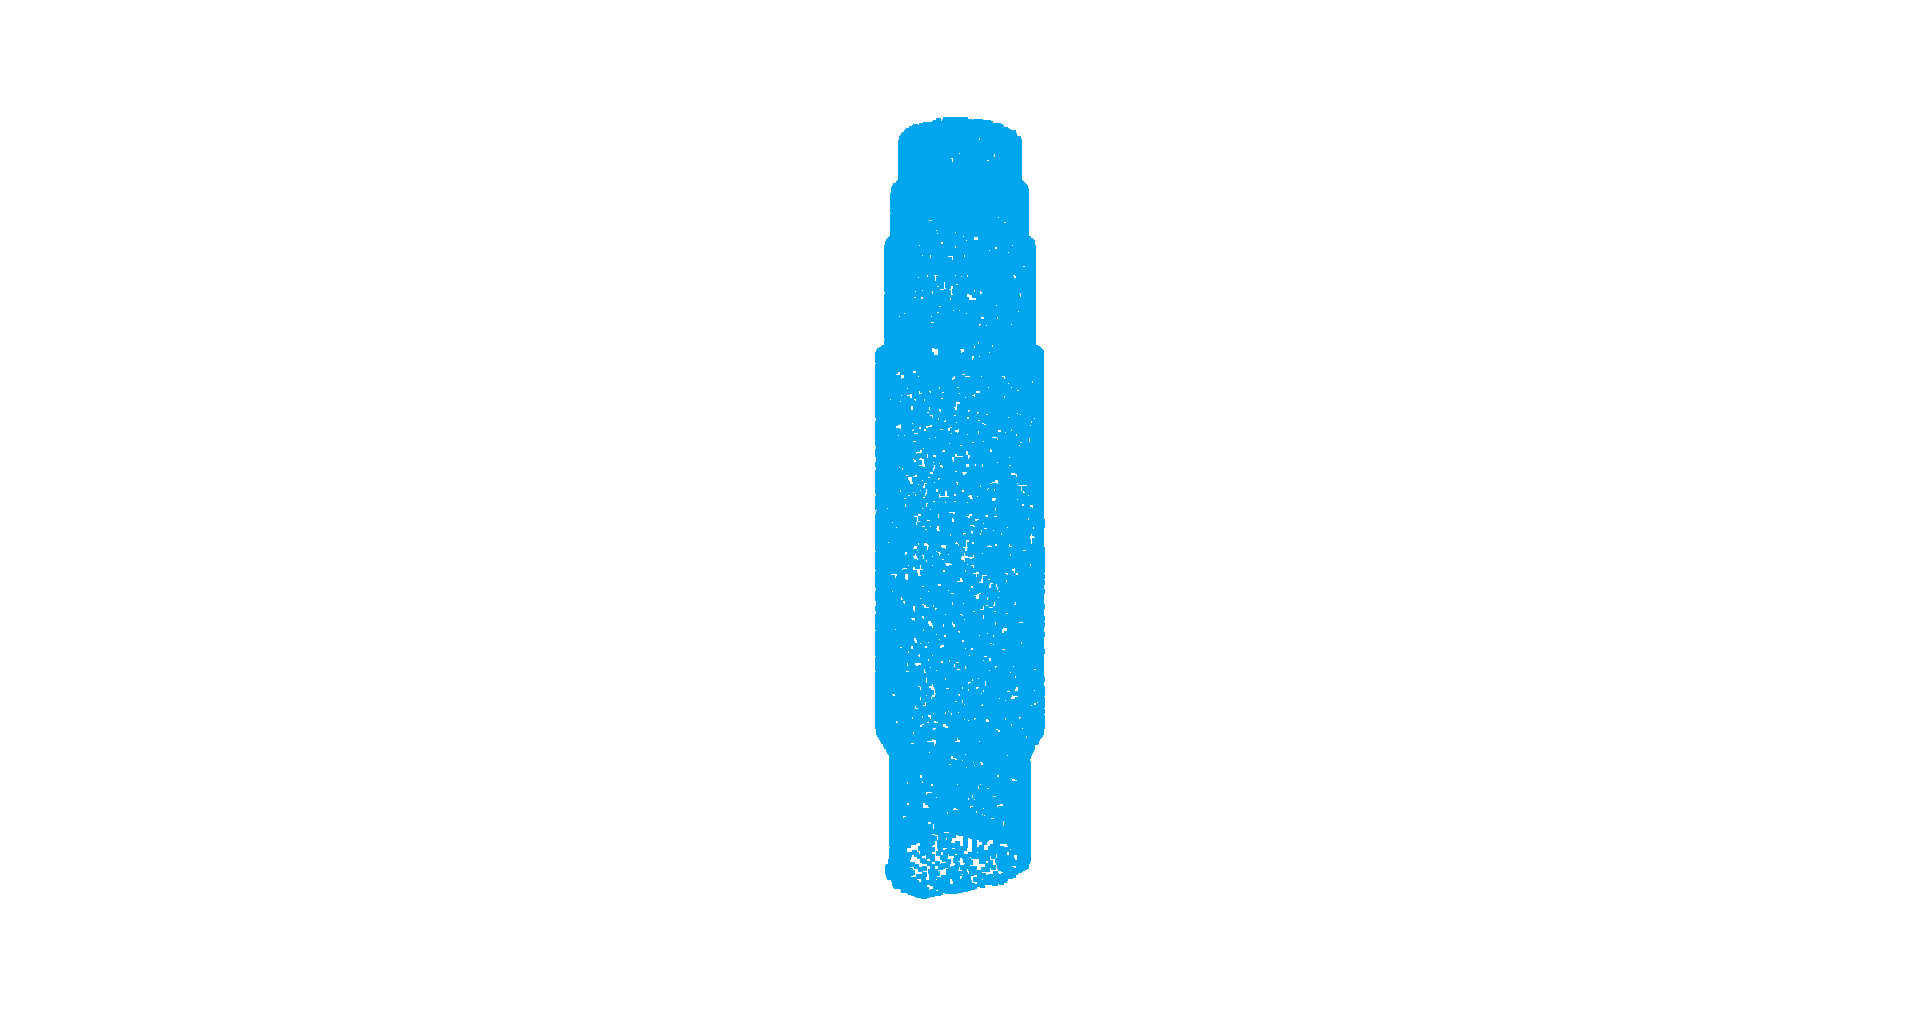


点云点坐标样例：


array([[ -6.956138, -82.149133,   3.735088],
       [ -6.868112, -82.088764,   3.959633],
       [ -6.938749, -82.120882,   3.805235],
       [ -6.781897, -82.080139,   4.101665]])

In [2]:
def txt2PointCloud(path):
    """
    txt 到 点云
    :param path: 文件路径
    :return: pcd 点云文件
    """
    with open(path) as temp:
        points = temp.read()
        points = points.strip().split('\n')

        PointXYZ = []
        for i in points:
            PointXYZ.append([float(x) for x in i.split(' ')])

    temp = np.asarray(PointXYZ)
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(temp)
    return source

# 读取扫描的 .txt 格式点云数据文件
FilePath = "../data/pz.txt"
source = txt2PointCloud(FilePath)
source.paint_uniform_color([0, 0.651, 0.929])
o3d.visualization.draw_geometries([source])

print("\n点云点坐标样例：")
np.asarray(source.points)[:4, :]

#### 1.1 直通滤波numpy实现

In [3]:
# 直通滤波 PassThrough Filter
def PassThroughFilter(pcd, fieldName, limits, limitsNegative=False):
    """
    点云直通滤波
    :param pcd: 点云数据
    :param fieldName: 坐标轴 'x', 'y', 'z'
    :param limits: 过滤区间
    :param limitsNegative: 是否反选, 默认limits区间
    :return: 过滤后pcd, 过滤后剩余的点云坐标index
    """
    dictXYZ = {'x':0, 'y':1, 'z':2}
    source = np.asarray(pcd.points)

    # 判断滤波坐标轴
    try:
        xyz = dictXYZ[fieldName]
    except KeyError:
        print('滤波轴选择错误, 请选坐标轴 \'x\', \'y\', \'z\'')

    # 计算左右区间
    if limitsNegative:
        indexLeft = limits[0] >= source[:, xyz]
        indexRight = limits[1] <= source[:, xyz]
    else:
        indexLeft = limits[0] <= source[:, xyz]
        indexRight = limits[1] >= source[:, xyz]

    # 合并区间, 滤波
    index = np.logical_and(indexLeft, indexRight)
    PCD = source[index, :]

    # ndarray到pcd
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(PCD)
    return pcd, index

# 滤波
filtered, index = PassThroughFilter(source, 'y', [-50, 1], False)

#### 1.2 `<PointCloud>.select_by_index`实现

在翻看文档的过程中，注意到`Open3D`提供了`<PointCloud>.select_by_index`函数，可以依下标采样。

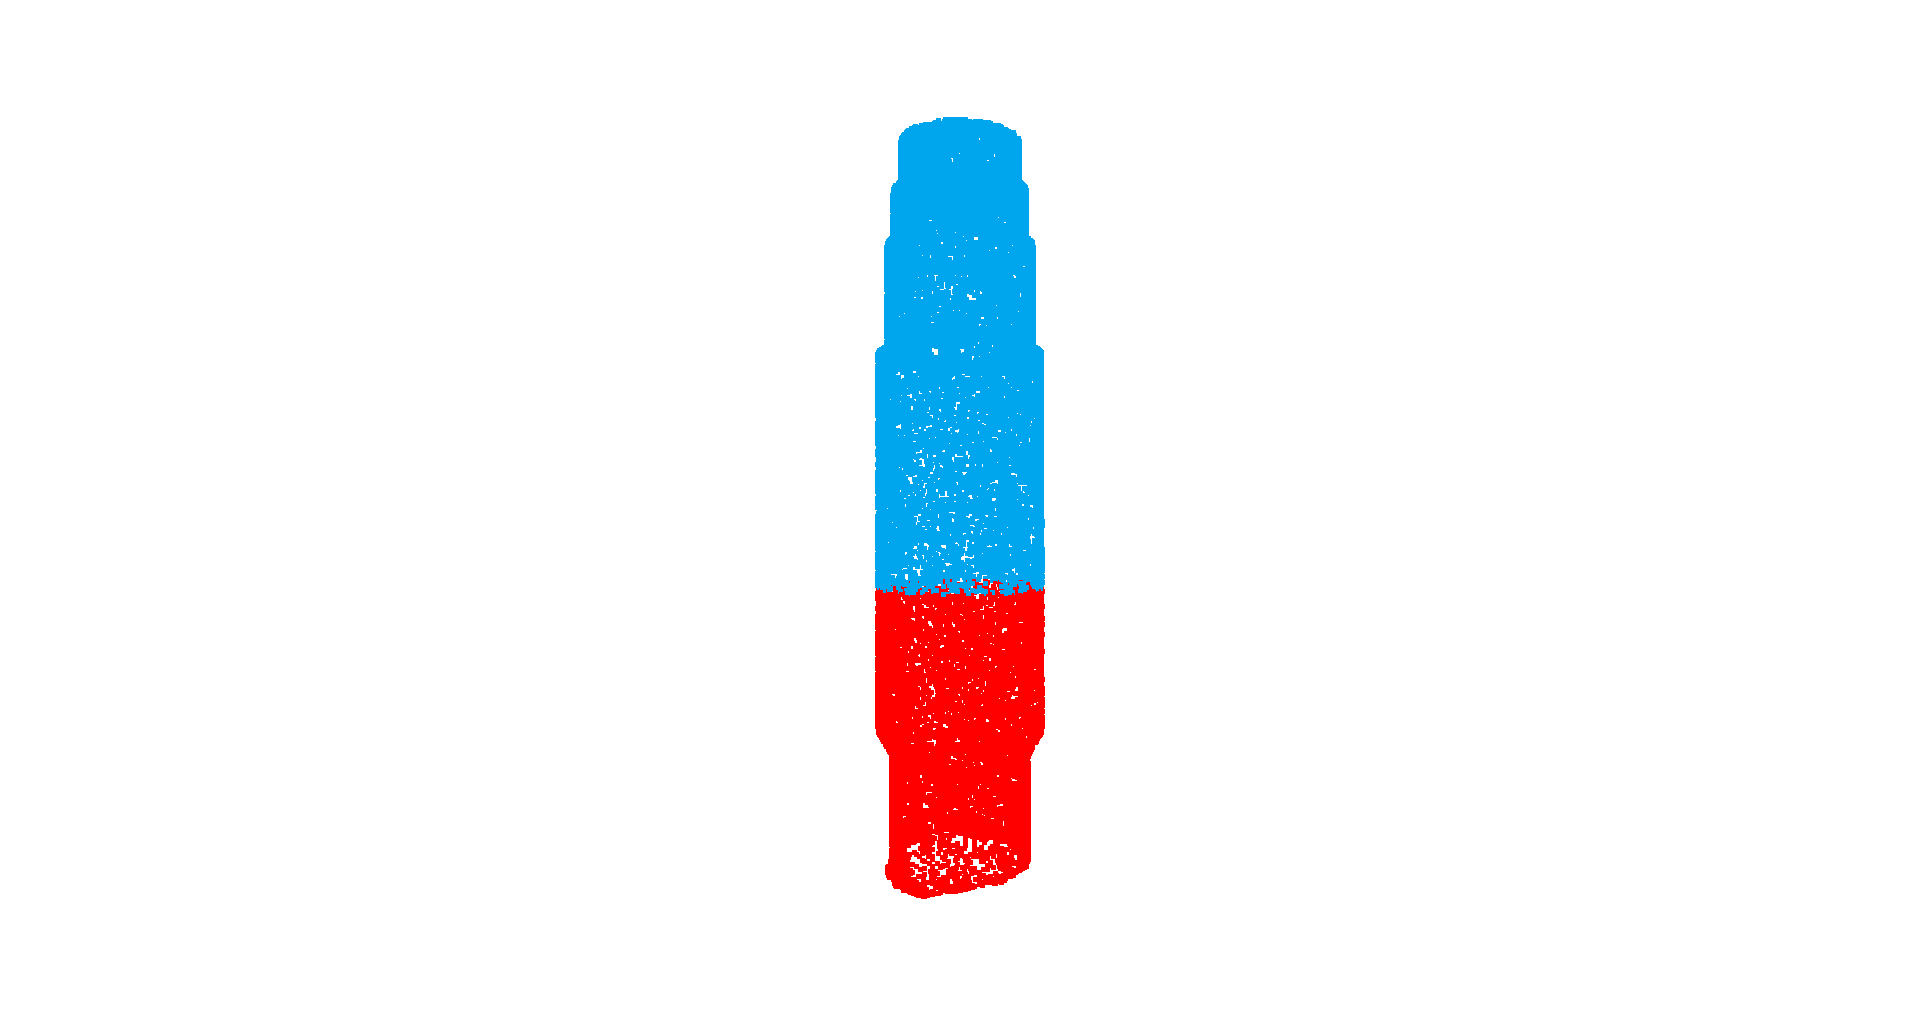

In [4]:
# index 采用上述自编程序的返回值
filtered = source.select_by_index([i for i, I in enumerate(index) if I])
filtered.paint_uniform_color([0, 0.651, 0.929])
# 反选坐标
outlier = source.select_by_index([i for i, I in enumerate(index) if I], invert=True)
outlier.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([filtered, outlier],
                                    window_name="1.点云直通滤波")

### 2. 体素采样

知识点:
> 体素法滤波，即减少点的数量，减少点云数据，并同时保持点云的形状特征，在提高配准、曲面重建、形状识别等算法速度中非常实用。 PCL实现的VoxelGrid类通过输入的点云数据创建一个三维体素栅格(可把体素栅格想象为微小的空间三维立方体的集合)，然后在每个体素（即三维立方体）内，用体素中所有***点的重心***来近似显示体素中其他点，这样该体素内所有点就用一个重心点最终表示，对于所有体素处理后得到过滤后的点云。
> 优缺点：这种方法比用体素中心来逼近的方法更慢，但它对于采样点对应曲面的表示更为准确。

体素不仅能表征点云表面特征, 还能完成对点云结构内部的描述. 尽管一开始不太容易理解, 但相信如果结合具体的应用实例, 应该可以更好地认识到体素的优势所在.

#### 2.1 体素降采样

`Open3D`中有 `<PointCloud>.voxel_down_sample`，其中的参数`voxel_size`的选择需要根据点云的实际稀疏调整。
此外还有一些可以查明的点：

+ [x] Open3D中，体素采样可能是中心而非PCL的重心。
+ [x] 三维体元素中，重心和中心的关系如何？
   > 立体几何的解释是:  n 维空间中一个对象X的几何中心或形心是将X分成矩相等的两部分的所有超平面的交点。非正式地说，它是X中所有点的平均。如果一個物件質量分佈平均，形心便是重心。

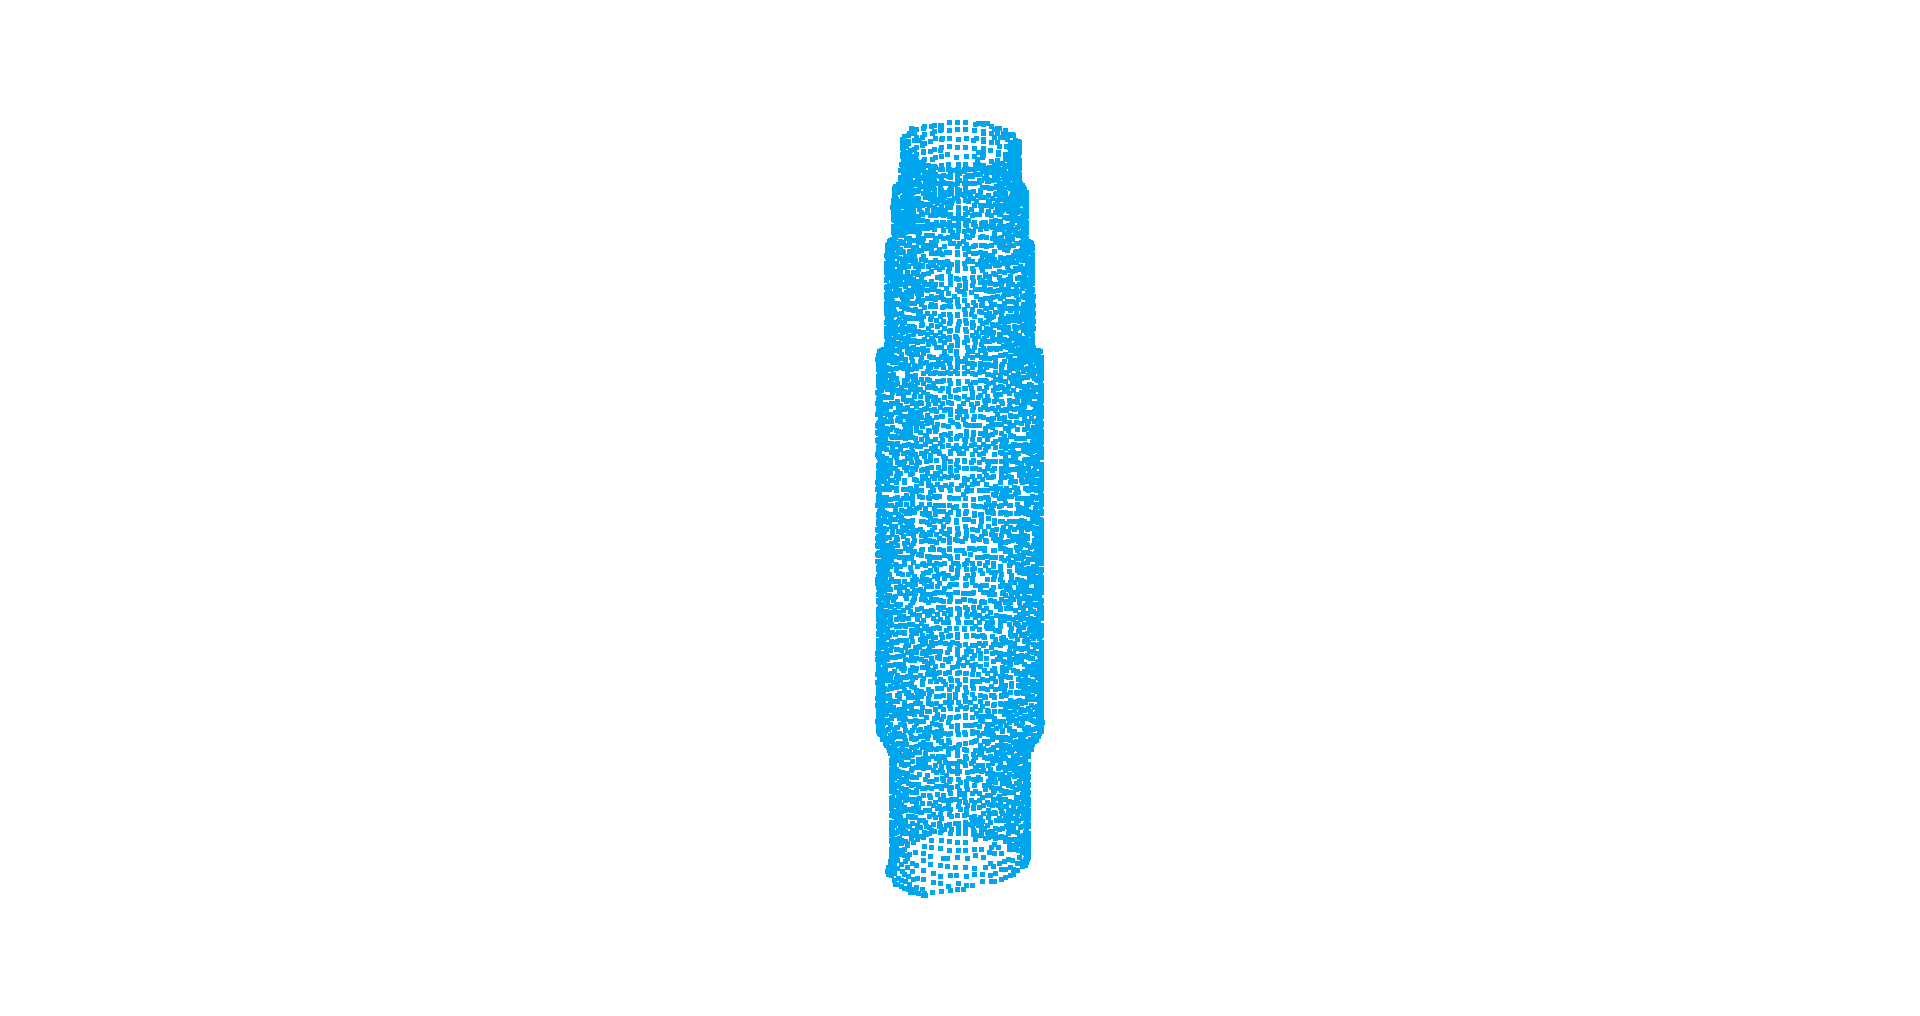

In [5]:
voxel_size = 0.9
downPCD = source.voxel_down_sample(voxel_size=voxel_size)
downPCD.paint_uniform_color([0, 0.651, 0.929])

# 显示
o3d.visualization.draw_geometries([ downPCD],
                                  window_name="2.1.体素降采样")

#### 2.2 一致降采样
`Open3D`还提供了另一种采样模式，`<PointCloud>.uniform_down_sample`，可以实现每k个点采样一个点。

对比*一致采样*和*体素采样*, 很明显, 体素采样能够更好地描述体的分布, 一致采样则更能忠实地保留点云数据点.

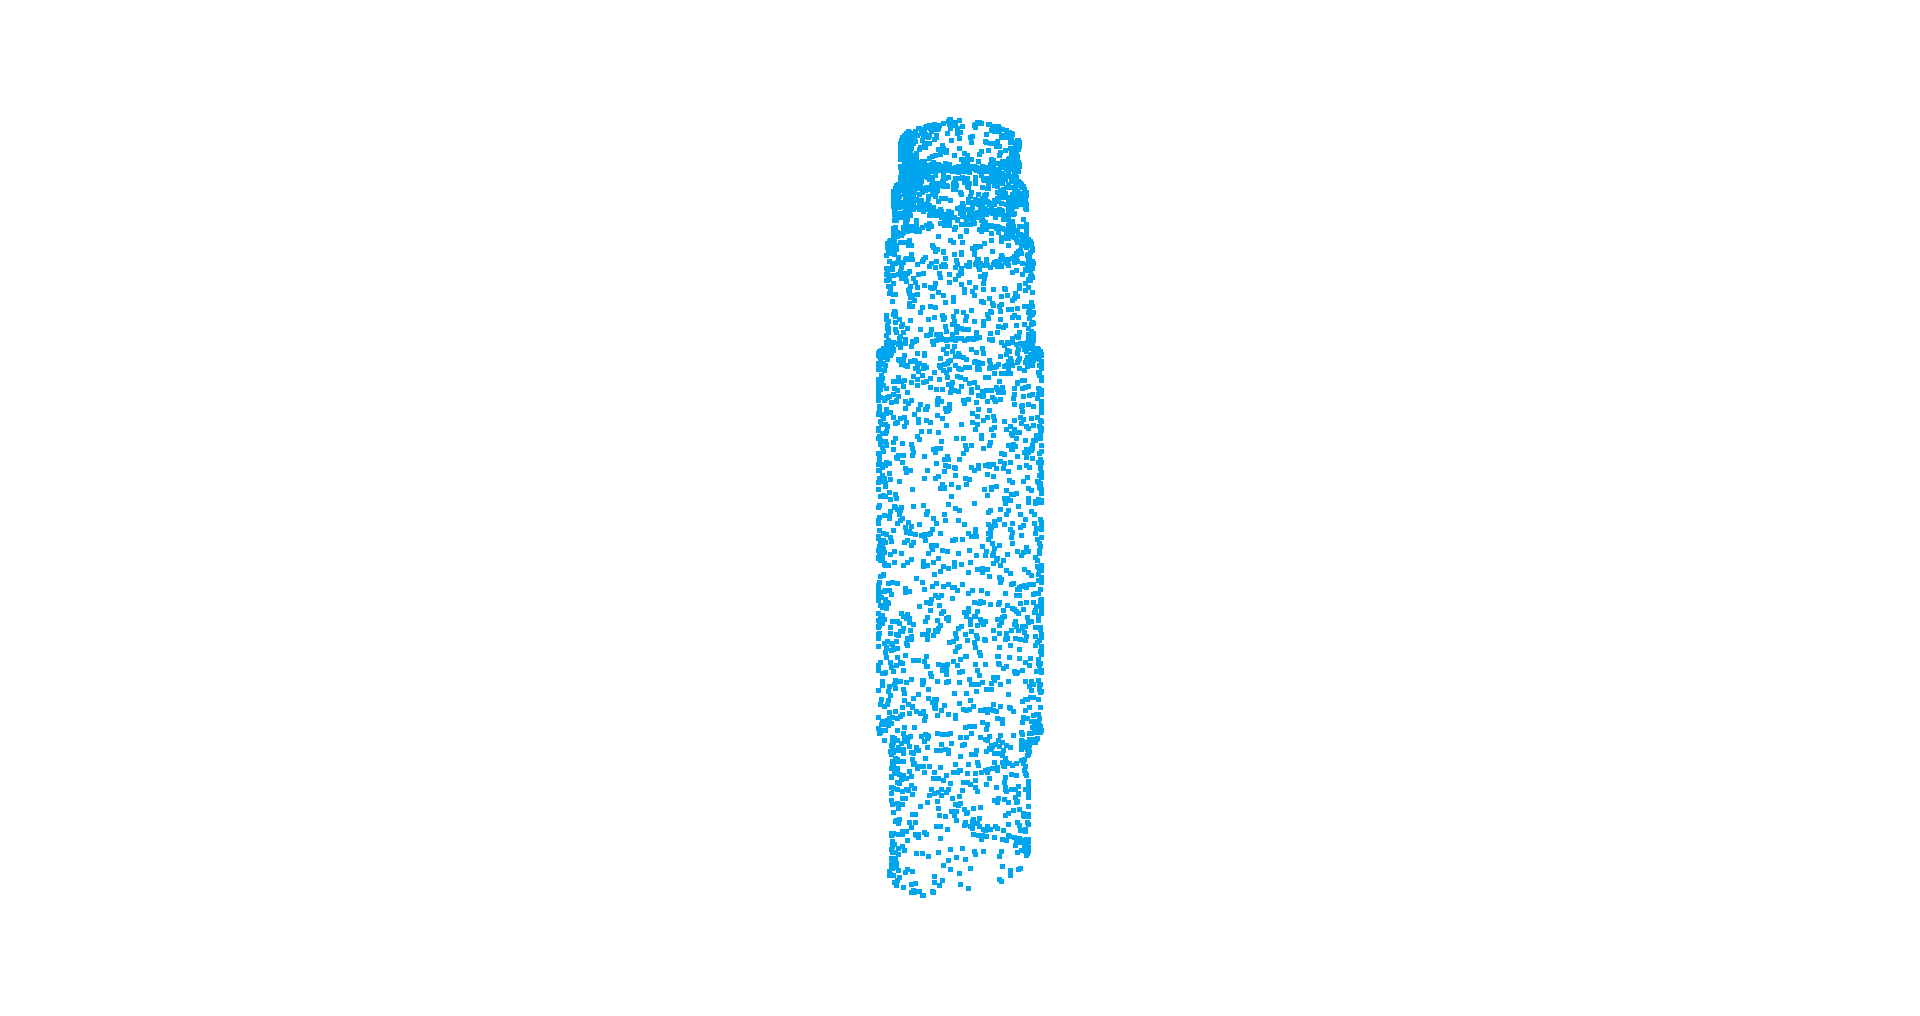

In [6]:
every_k_points = 8
uniformPCD = source.uniform_down_sample(every_k_points = every_k_points)
# 显示
o3d.visualization.draw_geometries([uniformPCD],
                                  window_name="2.2.一致降采样")

### 3. 统计滤波

知识点：
>统计滤波即是`PCL`中的`StatisticalOutlierRemoval`滤波器，主要可以用来剔除离群点，或者测量误差导致的粗差点。
>
> 滤波思想为：对每一个点及它的k个临近点进行统计分析，计算它到所有临近点的距离。假设k个距离呈高斯分布，其形状是由均值和标准差决定，那么距离在标准范围(由全局距离平均值和方差定义)之外的点，可以被定义为离群点并从数据中去除。

在`Open3D`中对应的函数为`<PointCloud>.remove_statistical_outlier`，函数参数 *邻域点数nb_neighbors*, *标准偏差距离std_ratio*

Statistical oulier removal
: [============================>           ] 70%

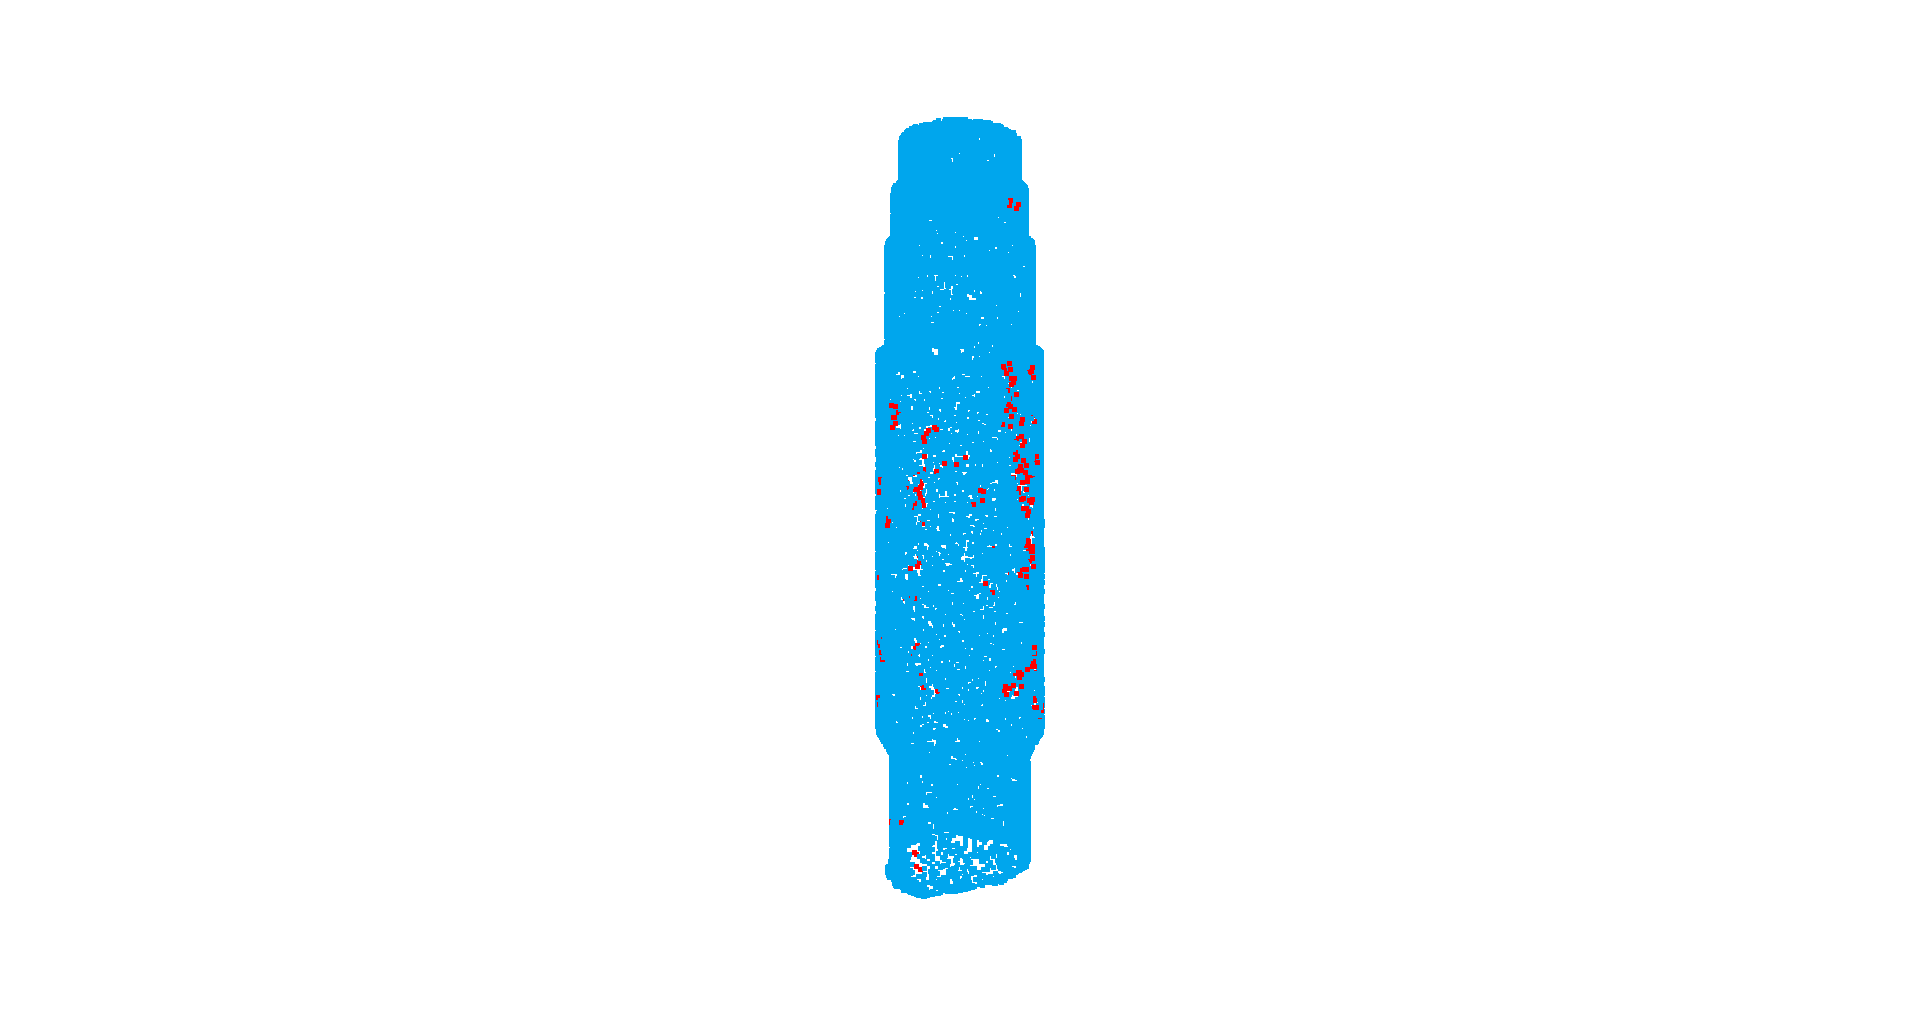

In [7]:
print("Statistical oulier removal")
# 邻域点数nb_neighbors 标准偏差距离std_ratio
filtered, ind = source.remove_statistical_outlier(nb_neighbors=20, std_ratio=2)
outlierPoints = source.select_by_index(ind, invert=True)

filtered.paint_uniform_color([0, 0.651, 0.929])
outlierPoints.paint_uniform_color([1, 0, 0])
# 显示滤波结果和滤除点
o3d.visualization.draw_geometries([filtered, outlierPoints],
                                  window_name="3.统计滤波")

### 4. 条件滤波

条件滤波是`PCL`中的`ConditionalRemoval`，提供了比直通滤波`PassThrough`更丰富灵活的坐标滤波限制。

<center>

|  属性   | 含义  |
|  :----:  | :----:  |
| GT  | 大于 |
| EQ  | 等于 |
|  LT | 小于 |
|  GE | 大于或等于 |
|  LE | 小于或等于 |

</center>

具体实现上，还是以`PassThrough`为蓝本，增删功能。为了方便管理和调用, 定义了一个类:
1. 提供对 XZY 坐标的5种大小关系的分别存储功能
2. 能够对点云按照滤波规则进行滤波, 并返回滤过后的点和点坐标

In [8]:
import numpy as np
class ConditionalRemoval:
    """
    条件滤波类
    addComparison(self, xyz, rela, num)     添加过滤条件函数
    filtering(self)     滤波函数
    """

    def __init__(self, pcd):
        self.source = pcd
        self.pcd = np.asarray(pcd.points)

        temp = np.ones([3,1]) * np.inf
        # 存放xyz坐标范围
        self.boundary = np.concatenate((-1*temp, temp), axis=1)
        # 存放上下界是否取等
        self.edge = np.ones([3,2])
        # 存放滤波后点坐标
        self.index = np.ones(len(pcd.points))

    def addComparison(self, xyz, rela, num):
        """
        添加滤波条件函数
        :param xyz: 坐标轴 'x', 'y', 'z'
        :param rela: 对应关系 'GT':大于 'EQ':等于 'LT':小于 'GE':大于或等于 'LE':小于或等于
        :param num: 数值
        :return: bool
        """
        dictXYZ = {'x':0, 'y':1, 'z':2}
        dictRela = {'GT':0, 'LT':0, 'EQ':1, 'GE':1,'LE':1}

        # 判断滤波坐标轴
        try:
            xyz = dictXYZ[xyz]
        except KeyError:
            print('滤波轴选择错误, 请选坐标轴 \'x\', \'y\', \'z\'')
            return False

        # 判断条件规则
        try:
            Rela = dictRela[rela]
        except KeyError:
            print('条件比较规则错误, 请选 \'GT\', \'EQ\', \'LT\', \'GE\', \'LE\'')
            return False

        # EQ 情况
        if rela[0] == 'E':
            self.boundary[xyz, 0] = num
            self.boundary[xyz, 1] = num
            return True

        # GT GE 情况
        if rela[0] == 'G':
            self.boundary[xyz, 0] = num
            self.edge[xyz, 0] *= Rela
            return True

        # LT LE 情况
        if rela[0] == 'L':
            self.boundary[xyz, 1] = num
            self.edge[xyz, 1] *= Rela
            return True

    def filtering(self):
        """
        执行滤波函数
        :return: filteredPCD, index
        """

        for i, bou in enumerate(self.boundary):
            # 左边界
            if self.edge[i, 0]:
                indexLeft = bou[0] <= self.pcd[:, i]
            else:
                indexLeft = bou[0] < self.pcd[:, i]
            # 右边界
            if self.edge[i, 1]:
                indexRight = bou[1] >= self.pcd[:, i]
            else:
                indexRight = bou[1] > self.pcd[:, i]
            # 关系 与
            temp = np.logical_and(indexLeft, indexRight)
            self.index = np.logical_and(self.index, temp)
            arrayIndex = np.asarray([i for i, I in enumerate(self.index) if I])

        filtered = self.source.select_by_index(arrayIndex)

        return filtered, arrayIndex

- 新建`<ConditionalRemoval>`对象, 用点云初始化对象.
- 若干次调用`<ConditionalRemoval>.addComparison(xyz, rela, num)`, 增加过滤规则.
- 调用`<ConditionalRemoval>.filtering()`, 进行滤波.

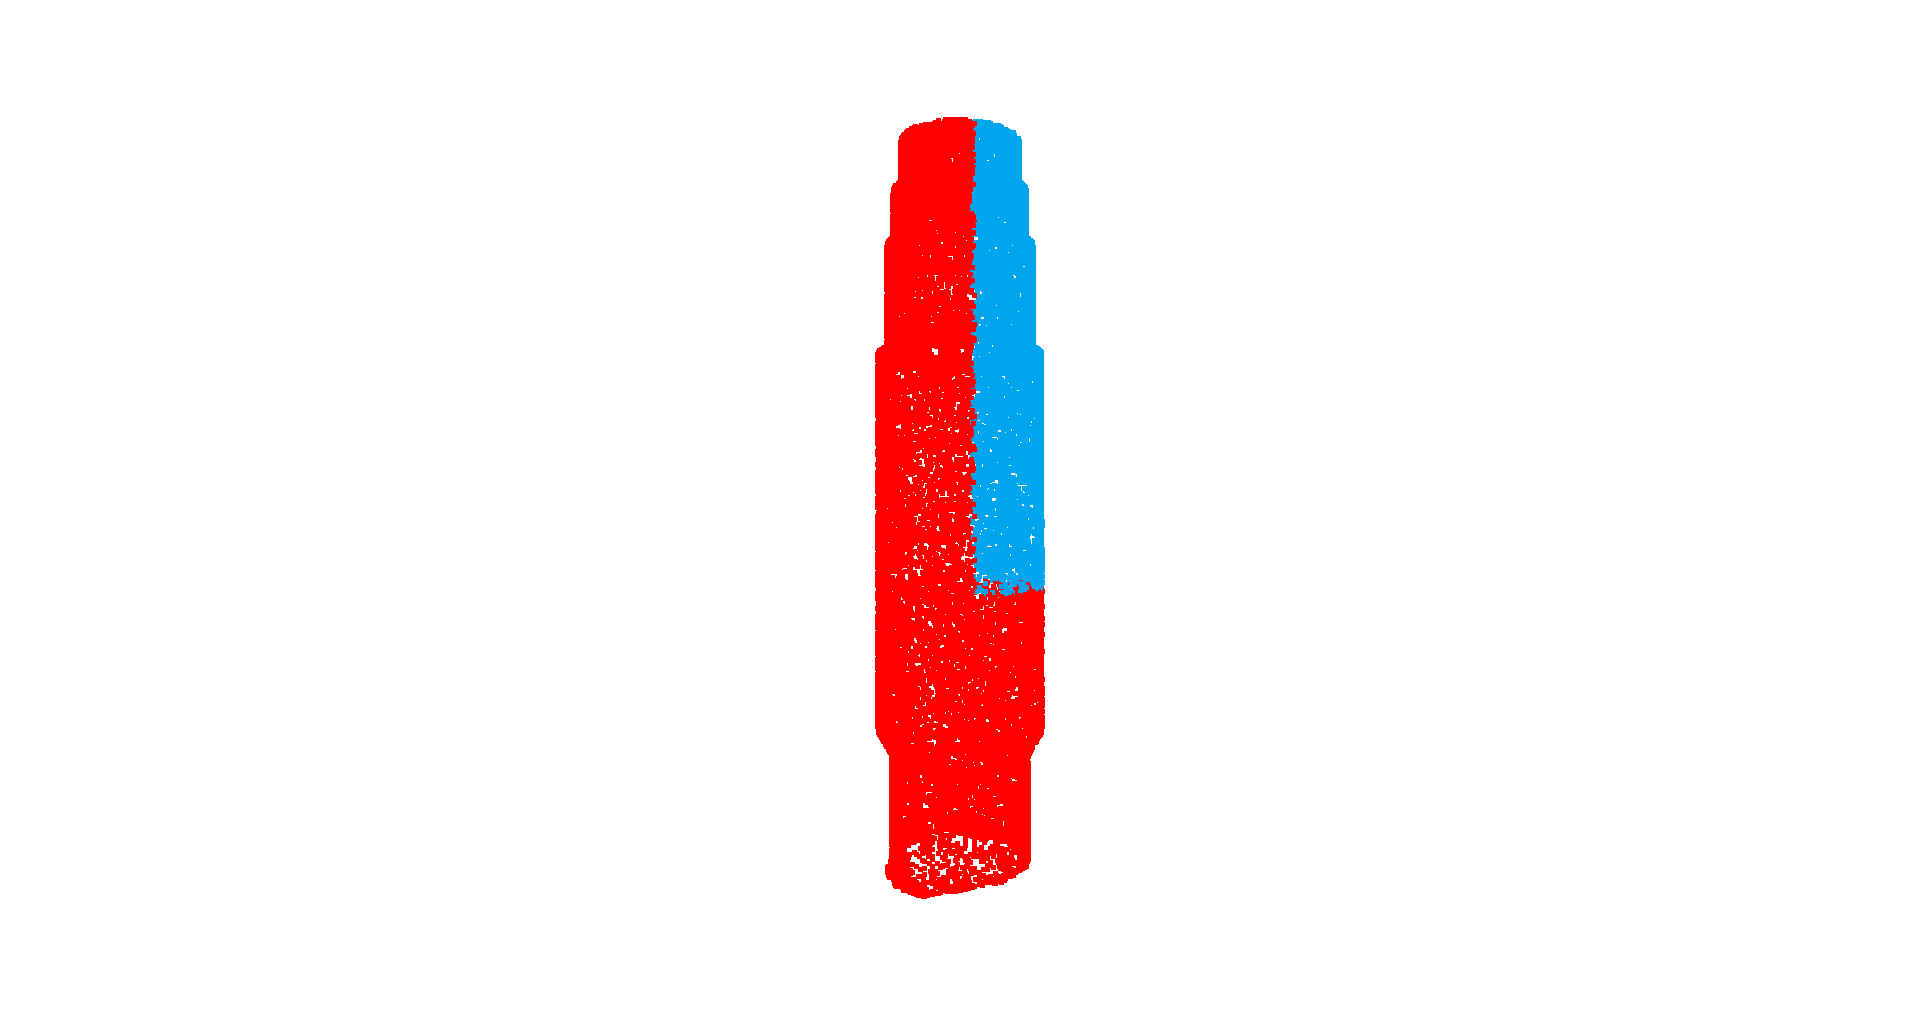

In [9]:
# 条件滤波并显示
# 条件滤波对象
CR = ConditionalRemoval(source)
# 添加比较条件
CR.addComparison('y', 'GT', -50)
CR.addComparison('y', 'LE', 2)
CR.addComparison('x', 'GE', 1.5)
# 进行滤波，点反选
filtered, index = CR.filtering()
outlierPoints = source.select_by_index(index, invert=True)
# 显示
filtered.paint_uniform_color([0, 0.651, 0.929])
outlierPoints.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([filtered, outlierPoints],
                                    window_name="4.条件滤波")

### 5. 半径滤波

`Open3D`提供了`<PointCloud>.radius_outlier_removal(nb_points, radius)`函数, 用于滤除以某点为中心, `radius`为半径范围内点云数量少于`nb_points`的点. 半径滤波的基本规则如下示意图所示.


<img src="../media/半径滤波.svg" alt="半径滤波示意图" width = 400>

Radius oulier removal
Remove statistical outliers: [========================================] 100%


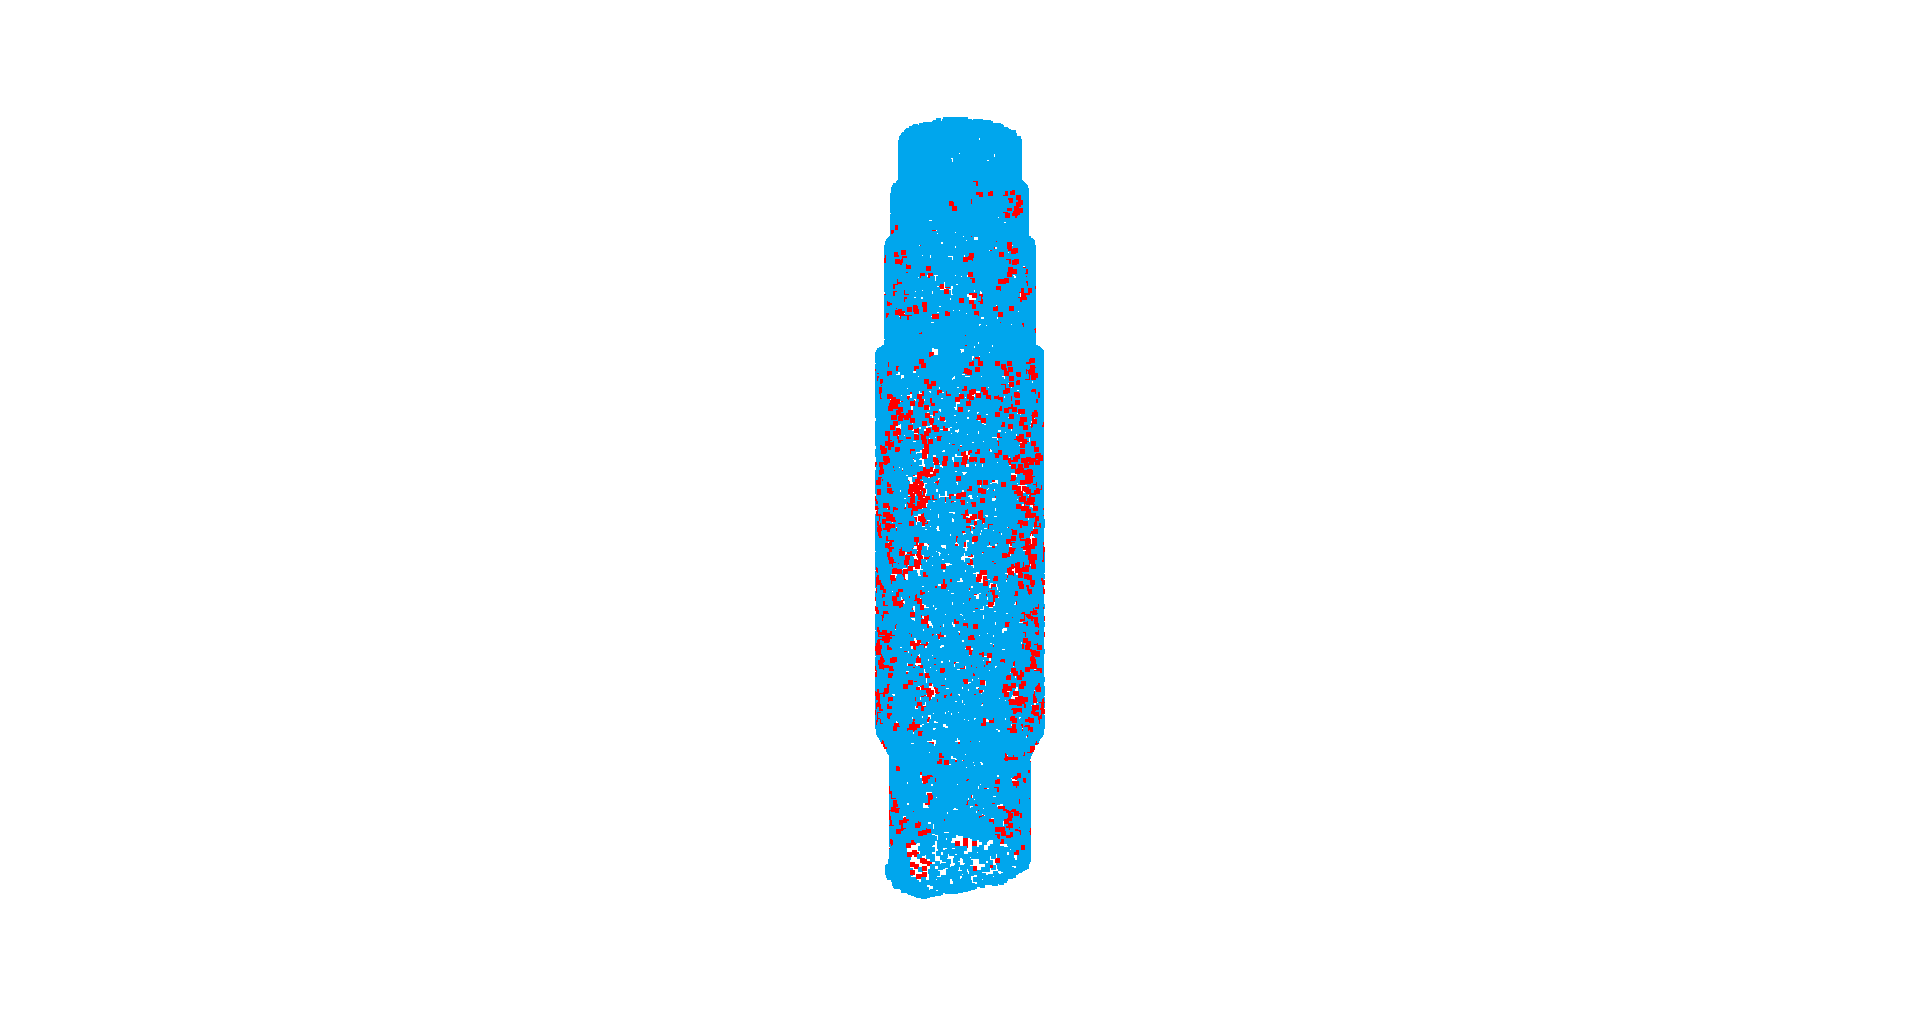

In [10]:
print("Radius oulier removal")
# 使用了选择阈值, 过滤点云
filtered, ind = source.remove_radius_outlier(nb_points=5, radius=0.8)
outlierPoints = source.select_by_index(ind, invert=True)
outlierPoints.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([filtered, outlierPoints],
                                  window_name="5.半径滤波")

### 6. 任意多边形提取

`Open3D`提供了基于`.json`文件的任意多边形提取对象`o3d.visualization.read_selection_polygon_volume(path)`

> 本质上, Open3D的多边形提取是在 XYZ中选择两轴, 如`YOZ平面`内, 画一个首尾相连的多边形, 该多边形沿`X轴`滑动, 获取所有落在多边形形成的柱体内的点云点.

下面展示了一个多边形提取的`JSON`文件, `axis_max`等限制了坐标范围, `bounding_polygon` 是某个正平面内的一个首位相连的多边形的点坐标. `orthogonal_axis`规定了该多边形的正交坐标轴, 显然, 多边形端点的该轴坐标值可以任意选取

```JSON
{
	"axis_max" : 400.022921085357666,
	"axis_min" : -1000.76341366767883301,
	"bounding_polygon" :
	[
		[ 2.6509309513852526, -50.0, -1000.6834473132326844 ],
		[ 2.5786428246917148, -50.0, -300.6892074266735244 ],
  		[ 0 ,                 -20.0, -1000.6819127849749496 ]
	],
	"class_name" : "SelectionPolygonVolume",
	"orthogonal_axis" : "X",
	"version_major" : 1,
	"version_minor" : 0
}
```

Load a polygon volume and use it to crop the original point cloud


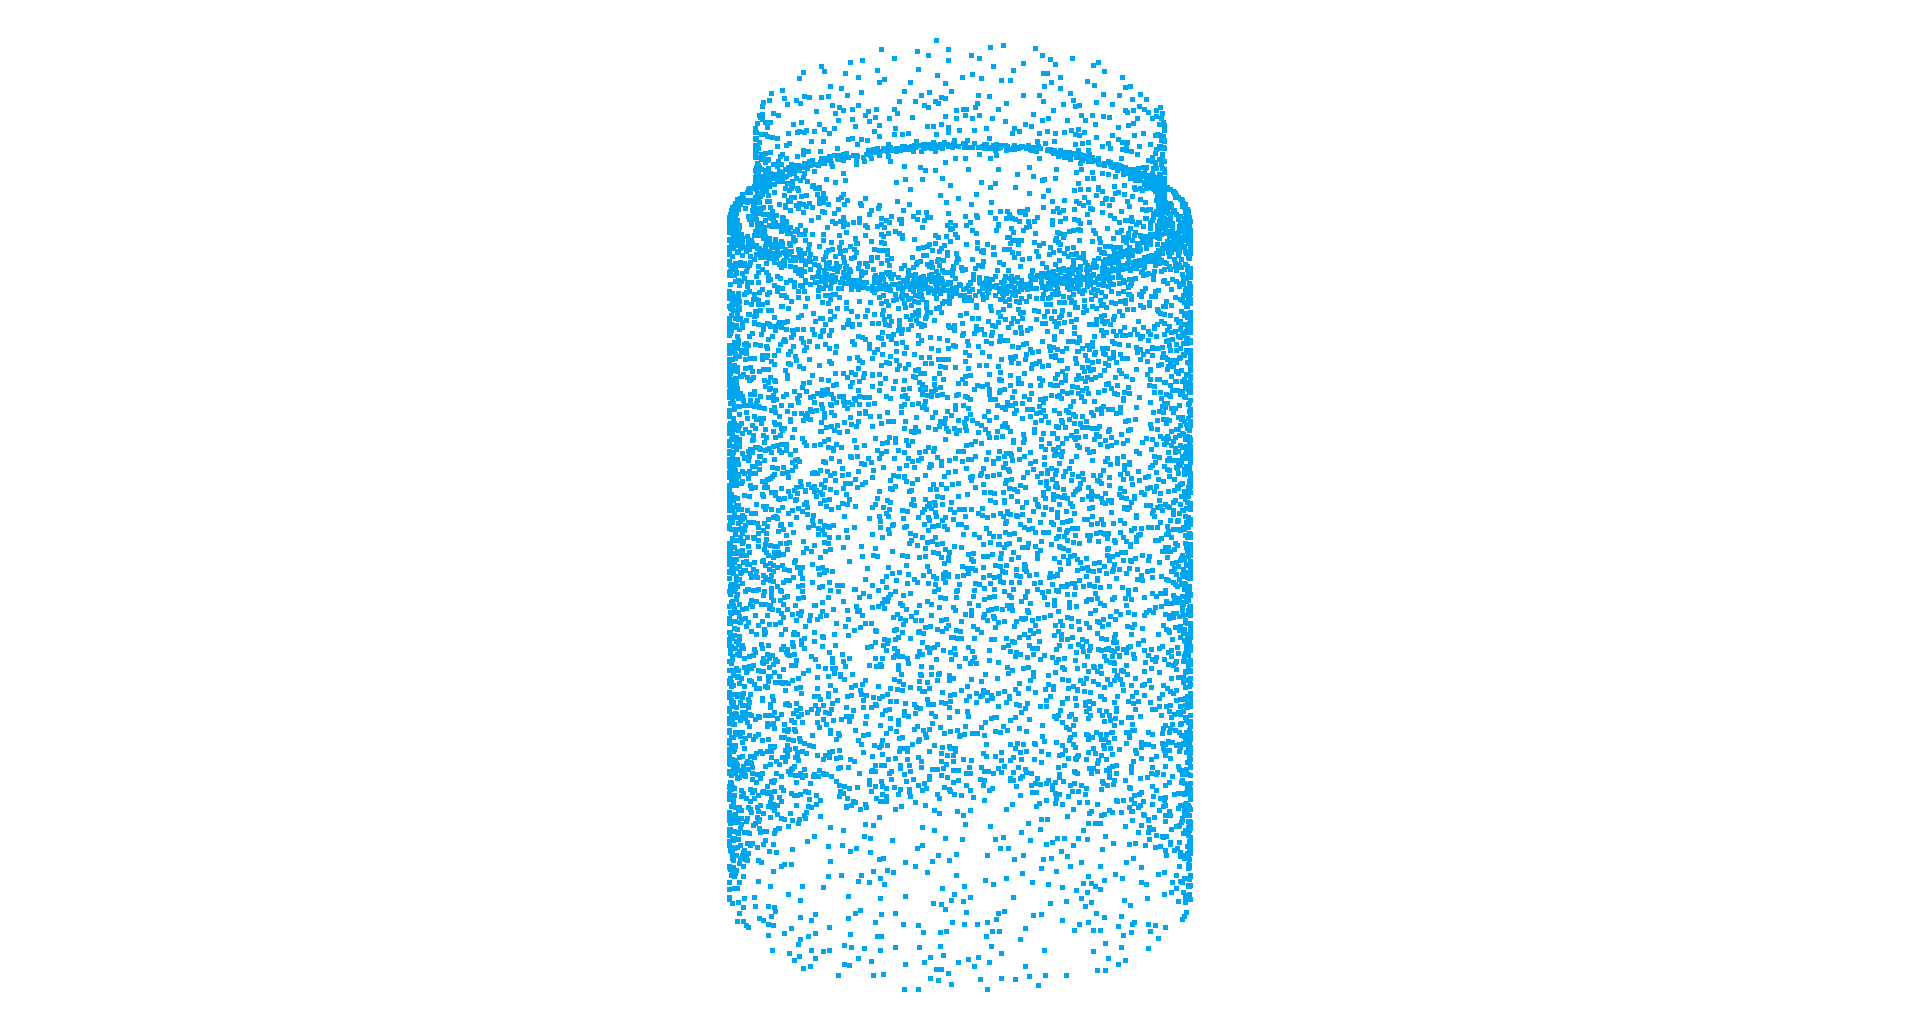

In [11]:
print("Load a polygon volume and use it to crop the original point cloud")
vol = o3d.visualization.read_selection_polygon_volume(
    "../data/pz_cropped.json")
chair = vol.crop_point_cloud(source)
o3d.visualization.draw_geometries([chair],
                                  window_name="6.任意多边形提取")

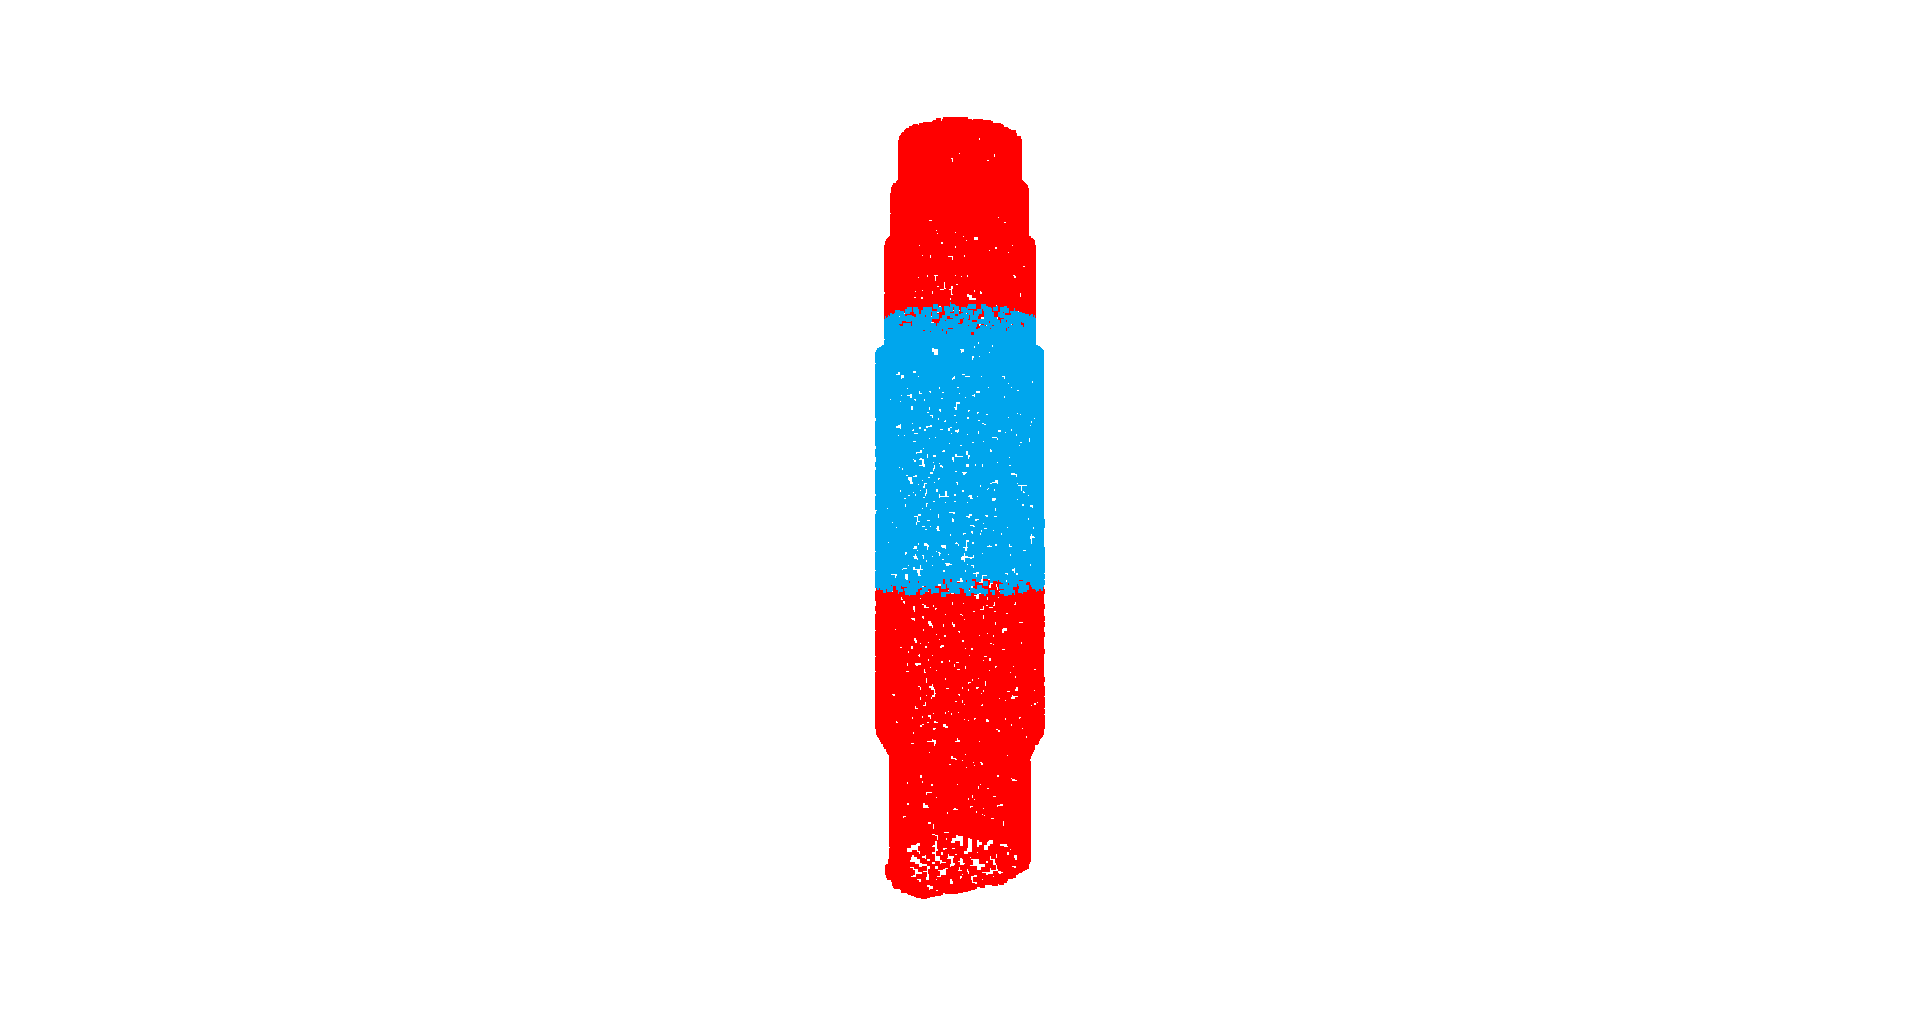

In [12]:
# 基于点云距离的反选
# 计算点云距离
dists = source.compute_point_cloud_distance(chair)
dists = np.asarray(dists)
# 距离阈值判断，其实原本点是0
ind = np.where(dists > 0.01)[0]
pcd_without_chair = source.select_by_index(ind)
pcd_without_chair.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([chair, pcd_without_chair],
                                  window_name="6.任意多边形提取")

结合`Numpy`, `Open3D`等常见的处理工具, 我们可以实现对点云数据的充分滤波, 尽管如此, 一些参数的选取还是需要手动的充分调整, 多边形提取也不是很方便.